In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import subprocess

import common

def plot_kernels():
    # get a list of all kernels   
    kernels=df.reset_index()["kernel"].unique()
    colors=["green", "blue", "red"]

    for i in range(len(kernels)):
        kernel_data = df.xs(kernels[i], level=1,  drop_level=False).reset_index()
        plt.plot(kernel_data["n_rays"], kernel_data["Rps"], color=colors[i])


    plt.legend(kernels)
    plt.yscale("log")
    plt.xscale("log")
    plt.grid()


# Comparison OpenVDB vs. NanoVDB opn CPU vs NanoVDB on GPU

In [3]:
df = common.load_df("../data/2022-04-05_22-31-00_Xeon_6248_Tesla_T4.csv")
plt.rcParams["figure.figsize"] = (10, 8)
plot_kernels(df)


print(df.groupby("kernel").max()["MRps"].sort_values())
plt.show()

TypeError: plot_kernels() takes 0 positional arguments but 1 was given

Problem:

- Benchmark broke after 198.190.084 Rays (ca. 200M) 
- Next step would have been 224.507.359 (ca. 224M)
- Kernel Memory requirements (measured with sizeof()):
    - Input: Ray = 56B
    - Output: Coord = 12B (3x float)
    - Output: time = 4B (1x float)

- => Memory required per Ray 72B
- 200M Rays = 14.4 GB
- 224M Rays = 16.1 GB
- Tesla T4 has 16 GB


Note:
- Ray should consist of 2x Vec3f = 6 float = 24B => $\approx$ 47% overhead



# Load Factor

kernel
NanoVDB_GPU    457.069
Name: MRps, dtype: float64


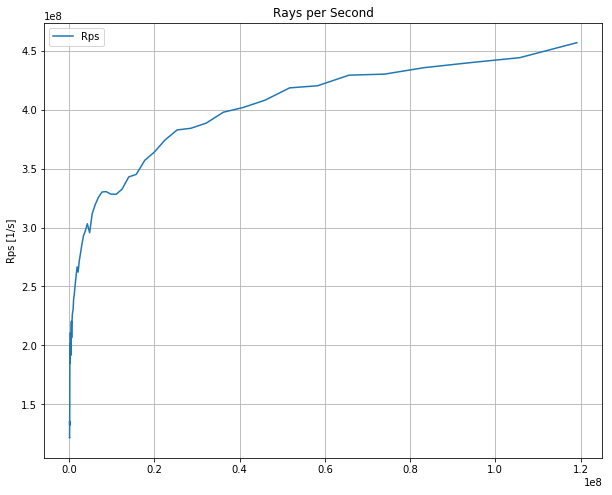

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)

df = common.load_df("../data/2022-04-07_22-29-16_gpu_short_name_loadfactor_50.csv").reset_index()

plt.plot(df["n_rays"], df["Rps"])
plt.legend()
plt.grid()
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("Rps [1/s]")
plt.title("Rays per Second")


print(df.groupby("kernel").max()["MRps"].sort_values())
plt.show()


# Ray Shuffling

kernel
OpenVDB        17.2963
NanoVDB_CPU    26.9774
NanoVDB_GPU    99.2817
Name: MRps, dtype: float64


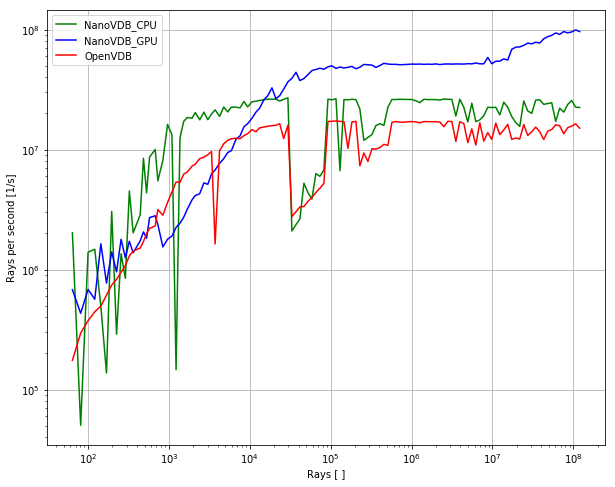

In [ ]:
df = common.load_df("../data/2022-04-07_23-07-51_gpu_short_name_loadfactor_1_shuffled.csv")
plot_kernels(df)



print(df.groupby("kernel").max()["MRps"].sort_values())
plt.show()

# Sphere offset


kernel
OpenVDB         22.5633
NanoVDB_CPU     34.4333
NanoVDB_GPU    179.0200
Name: MRps, dtype: float64


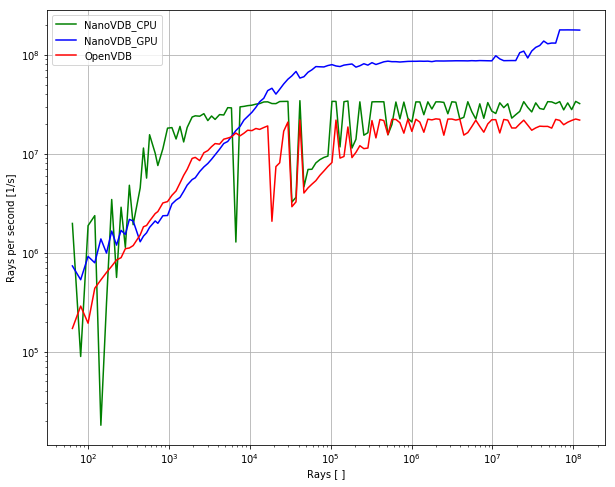

In [ ]:
df = common.load_df("../data/2022-04-07_23-52-28_gpu_short_name_loadfactor_1_offset_shuffled.csv")
plot_kernels(df)



print(df.groupby("kernel").max()["MRps"].sort_values())
plt.show()

# With load factor again:
- Shuffling
- No checks
- Load factor = 100
- better level set params
- sphere offset = 2


Speedup OpenVDB -> NanoVDB = 6.34
kernel
OpenVDB         18.5132
NanoVDB_CPU     29.6971
NanoVDB_GPU    117.4190
Name: MRps, dtype: float64


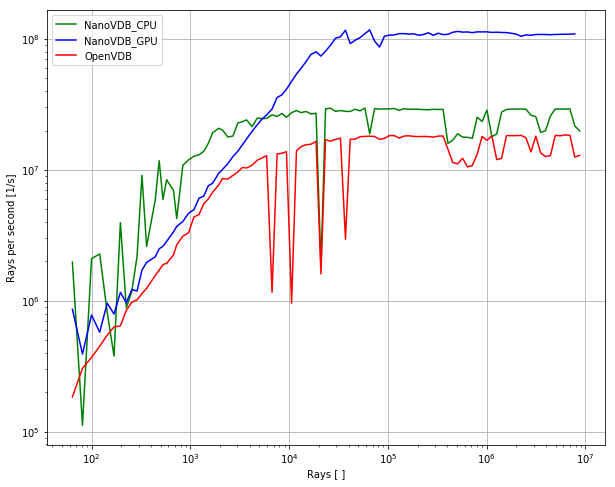

In [ ]:
df = common.load_df("../data/2022-04-08_01-00-21_gpu_short_name_loadfactor_100_shuffling.csv")

plot_kernels(df)

best = df.groupby("kernel").max()["MRps"].sort_values()
print(f"Speedup OpenVDB -> NanoVDB = {best['NanoVDB_GPU'] / best['OpenVDB']:.3}")
print(best)
plt.show()


# Same as above but no shuffle


Speedup OpenVDB -> NanoVDB = 19.0
kernel
OpenVDB         20.3086
NanoVDB_CPU     32.1388
NanoVDB_GPU    386.0970
Name: MRps, dtype: float64


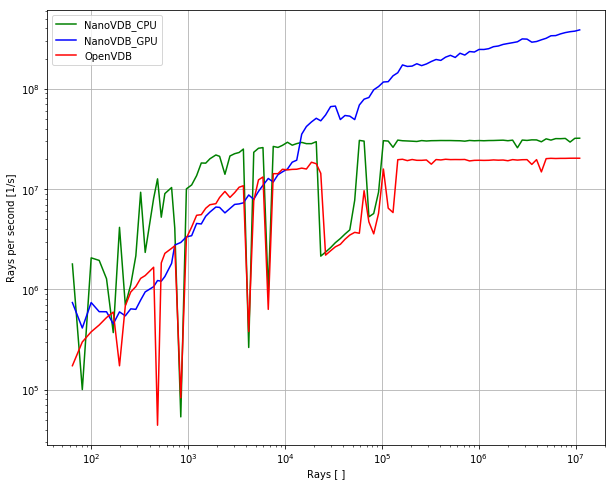

In [ ]:
df = common.load_df("../build/2022-04-08_01-02-54_gpu_short_name_loadfactor_100.csv")
plot_kernels(df)

best = df.groupby("kernel").max()["MRps"].sort_values()
print(f"Speedup OpenVDB -> NanoVDB = {best['NanoVDB_GPU'] / best['OpenVDB']:.3}")
print(best)
plt.show()


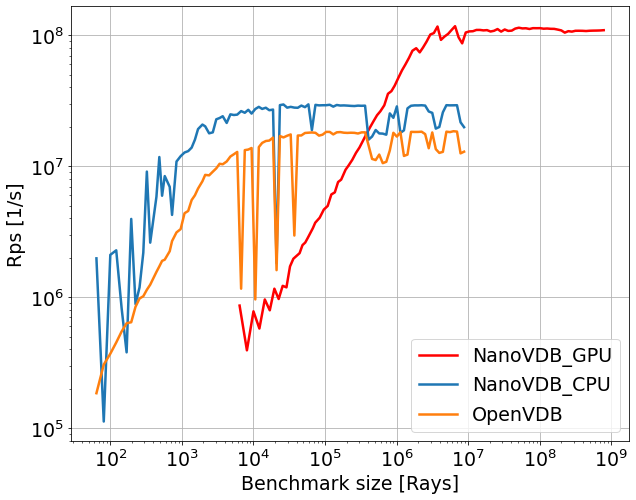

In [5]:
plt.rcParams["figure.figsize"] = (10, 8)
df = common.load_df("../data/2022-04-08_01-00-21_gpu_short_name_loadfactor_100_shuffling.csv").reset_index()
df["n_rays_adjusted"] = df[df["kernel"] == "NanoVDB_GPU"]["n_rays"]*100

kernels = ["NanoVDB_GPU", "NanoVDB_CPU", "OpenVDB"]
colors=["green", "blue", "red"]

for kernel in kernels:
    kernel_df = df[df["kernel"] == kernel] 
    if kernel == "NanoVDB_GPU":
        plt.plot(kernel_df["n_rays_adjusted"], kernel_df["Rps"], color="red", linewidth=2.5)
    else:
        plt.plot(kernel_df["n_rays"], kernel_df["Rps"], linewidth=2.5)

fontsize=19
plt.legend(kernels, fontsize=fontsize)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Benchmark size [Rays]", fontsize=fontsize)
plt.ylabel("Rps [1/s]", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.savefig(common.globals["paths"]["res_dir"] + "/results.pdf")

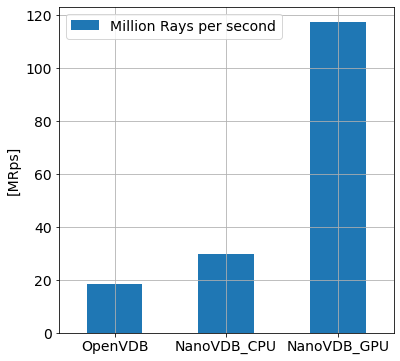

In [ ]:
fontsize=14
plt.rcParams["figure.figsize"] = (6, 6)
df.groupby("kernel").max().sort_values(by="MRps").plot.bar(y="MRps", rot=0, fontsize=fontsize, width=0.5)
plt.xlabel("")
plt.grid()
plt.ylabel("[MRps]", fontsize=fontsize)
plt.legend(["Million Rays per second"], fontsize=fontsize)
plt.savefig(common.globals["paths"]["res_dir"] + "/barplot.pdf")
plt.show()

In [ ]:
df.groupby("kernel").max().sort_values(by="MRps")

,n_rays,time,Rps,Rps/Eur,Rps/W,n_blocks,n_threads,MRps,n_rays_adjusted
kernel,,,,,,,,,
OpenVDB,8755681,0.677616,18513200.0,5627.11,123421.0,1.0,1.0,18.5132,NaN
NanoVDB_CPU,8755681,0.440483,29697100.0,9026.46,197980.0,1.0,1.0,29.6971,NaN
NanoVDB_GPU,7817616,0.071446,117419000.0,46967.50,1677410.0,256.0,256.0,117.4190,781761600.0
